## Exercise Sheet 1: Recurrent Models

Compare Vanilla Recurrent Neural Networks (RNN) with Long-Short Term Networks (LSTM). Implement a vanilla RNN and LSTM from scratch.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import json
import os
import time
import math
import sys
import numpy as np
import argparse

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.functional as F

# import RNN from torch
from torch.nn import RNN

import matplotlib.pyplot as plt
%matplotlib inline

# set seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set paths
data_path = 'data/'
model_path = 'model/'
results_path = 'results/'

# make directories if they don't exist
if not os.path.exists(data_path):
    os.makedirs(data_path)
if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(results_path):
    os.makedirs(results_path)


# Data
p1 = [5, 10, 15, 20]
p2_acc_rnn = []
p3_acc_lstm = []

# Hyperparameters
config = {
    "input_length": 15,
    "input_dim": 1,
    "num_classes": 10,
    "num_hidden": 128,
    "batch_size": 128,
    "learning_rate": 0.001,
    "train_steps": 10000,
    "test_steps": 100,
    "max_norm": 10.0
}

# save config
with open(model_path + 'config.json', 'w') as file:
    json.dump(config, file)

### Task 1: Toy Problem: Palindrome Numbers

Use a  a recurrent neural network to predict the next digit of the palindrome
at every timestep. This can become difficult for very long sequences since the network has to memorise information from very far away earlier timesteps. Goal is to study the memoization capability of recurrent networks.

In [2]:
class PalindromeDataset(data.Dataset):
    """ Randomly generates palindromes of a given length.
        The input is the first N-1 digits of the palindrome, the target is the last digit.
        For short palindromes, the number of possible palindromes is limited.
    """
    def __init__(self, seq_length):
        self.seq_length = seq_length

    def __len__(self):
        # Number of possible palindroms can be very big:
        # (10**(seq_length/2) or (10**((seq_length+1)/2)
        # Therefore we return the maximum integer value
        return sys.maxsize

    def __getitem__(self, idx):
        # Keep last digit as target label. Note: one-hot encoding for inputs is
        # more suitable for training, but this also works.
        full_palindrome = self.generate_palindrome()
        # Split palindrome into inputs (N-1 digits) and target (1 digit)
        return full_palindrome[0:-1], int(full_palindrome[-1])

    def generate_palindrome(self):
        # Generates a single, random palindrome number of 'length' digits.
        left = [np.random.randint(0, 10) for _ in range(math.ceil(self.seq_length / 2))]
        left = np.asarray(left, dtype=np.float32)
        right = np.flip(left, 0) if self.seq_length % 2 == 0 else np.flip(left[:-1], 0)
        return np.concatenate((left, right))


In [3]:
class VanillaRNN(nn.Module):

    def __init__(
        self, seq_length, input_dim, num_hidden, num_classes, batch_size, device=None):
        super(VanillaRNN, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.batch_size = batch_size

        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.device = device

        # Define the RNN layer
        self.W_hx = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))      # input to hidden
        self.W_hh = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))     # hidden to hidden
        self.B_h = nn.Parameter(torch.Tensor(self.num_hidden))                       # hidden bias
        # Define the output layer
        self.W_ph = nn.Parameter(torch.Tensor(self.num_hidden, self.num_classes))    # hidden to output
        self.B_y = nn.Parameter(torch.Tensor(self.num_classes))                      # output bias

        # Initialize weights
        self.init_weights()

    def forward(self, x):
        # Initialize hidden state
        h_t = torch.zeros(self.batch_size, self.num_hidden)
        for t in range(self.seq_length): # iterate over the time steps
            x_t = x[:, t].view(128,-1)
            h_t = torch.tanh(x_t @ self.W_hx + h_t @ self.W_hh + self.B_h)

        output = h_t @ self.W_ph + self.B_y
        y = torch.softmax(output, dim=1)
        return y

    def init_weights(self):
        """ Keep weights in a similar range to avoid
            gradients vanishing or exploding.
        """
        # Initialize weights
        nn.init.xavier_normal_(self.W_hx)
        nn.init.xavier_normal_(self.W_hh)
        nn.init.xavier_normal_(self.W_ph)
        nn.init.zeros_(self.B_h)
        nn.init.zeros_(self.B_y)

    def init_hidden(self):
        # Initialize hidden state
        self.hidden_state = torch.zeros(self.batch_size, self.num_hidden, device=self.device)

    def set_grad(self, requires_grad):
        # Set requires_grad for all parameters
        for param in self.parameters():
            param.requires_grad = requires_grad

In [4]:
def compute_accuracy(outputs, targets):
    """ Compute the accuracy of the model's predictions."""
    # Compute accuracy of outputs compared to targets
    _, predicted = torch.max(outputs, 1)
    correct = predicted.eq(targets)
    return 100 * correct.sum().item() / targets.size(0)

In [5]:

def train(config:json, input_length=5, type='RNN', device=None):
    """ Train the model on the training set.
        Returns the trained model, losses and accuracies.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if input_length == 0:
        input_length = config['input_length']

    # Initialize the model that we are going to use
    if type == 'RNN':
        model = VanillaRNN(input_length, config['input_dim'], config['num_hidden'], config['num_classes'], config['batch_size'])
    elif type == 'LSTM':
        model = LSTM(input_length, config['input_dim'], config['num_hidden'], config['num_classes'], config['batch_size'])
    else:
        raise ValueError('Model type not supported')
    model.to(device)
    model.train()

    # Initialize the dataset and data loader (note the +1)
    dataset = PalindromeDataset(input_length + 1)
    data_loader = data.DataLoader(dataset, config['batch_size'], num_workers=0)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(model.parameters(), lr=config['learning_rate'])

    losses = []
    accuracies = []
    loss = 0.0

    for i, (inputs, targets) in enumerate(data_loader, 0):

        # Only for time measurement of step through network
        t1 = time.time()
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass, backward pass, and optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])

        loss += loss.item()
        accuracy = 0.0

        # Print statistics
        if i % 10 == 0:
            # Just for time measurement
            t2 = time.time()
            # print accuracy/loss here
            accuracy = compute_accuracy(outputs, targets)
            accuracies.append(accuracy)
            print('[step: %5d] loss: %.4f acc: %.4f time: %5d' %
                          (i, loss / 10, accuracy, t2-t1 / 10))
            losses.append(loss.detach().numpy() / 10)
            loss = 0.0

        if i == config['train_steps']:
            # If you receive a PyTorch data-loader error, check this bug report:
            # https://github.com/pytorch/pytorch/pull/9655
            break

    print('Finished Training')
    return model, losses, accuracies


def test(model, config:json, device=None):
    """ Test the model on the test set.
        Returns the accuracies.
    """
    if device is None:
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize the dataset and data loader (leave the +1)
    dataset = PalindromeDataset(config['input_length']+1)
    data_loader = data.DataLoader(dataset, config['batch_size'], num_workers=0)

    model.eval()

    # Test the model
    accuracies = []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader, 0):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            accuracy = 0.0
            if i % 10 == 0:
                accuracy = compute_accuracy(outputs, targets)
                accuracies.append(accuracy)
                print('Accuracy: %.4f' % accuracy)

            if i == config['test_steps']:
                break

    print('Finished Testing')
    return accuracies


In [6]:
# Load the configuration
with open(model_path + 'config.json', 'r') as file:
    config = json.load(file)

In [7]:
def plot_loss(losses, title='Training Loss', path=None):
    """ Plot the losses of the model."""
    if path is None:
        path = results_path + 'training_loss.png'
    plt.plot(losses)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title(title)
    plt.savefig(path)
    plt.show()

def plot_accuracy(accuracies, title='Training Accuracy', path=None):
    """ Plot the accuracies of the model."""
    if path is None:
        path = results_path + 'training_accuracy.png'
    plt.plot(accuracies)
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.savefig(path)
    plt.show()


#### Train and evaluate model on Palindromes with length N = 11

In [8]:
# Train the model on T=5
model, losses, accuracies = train(config, input_length=p1[0], type='RNN', device=device)
# Add accuracies
p2_acc_rnn.append(accuracies)

<ipython-input-5-bfc30801ac03>:50: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:     0] loss: 0.4624 acc: 6.2500 time: 1547222949
[step:    10] loss: 0.4354 acc: 28.1250 time: 1547222949
[step:    20] loss: 0.4309 acc: 28.9062 time: 1547222949
[step:    30] loss: 0.4148 acc: 45.3125 time: 1547222950
[step:    40] loss: 0.4112 acc: 42.9688 time: 1547222950
[step:    50] loss: 0.4034 acc: 48.4375 time: 1547222950
[step:    60] loss: 0.3970 acc: 50.0000 time: 1547222950
[step:    70] loss: 0.3942 acc: 53.1250 time: 1547222950
[step:    80] loss: 0.3967 acc: 44.5312 time: 1547222950
[step:    90] loss: 0.3717 acc: 75.0000 time: 1547222951
[step:   100] loss: 0.3683 acc: 69.5312 time: 1547222951
[step:   110] loss: 0.3642 acc: 71.8750 time: 1547222951
[step:   120] loss: 0.3816 acc: 52.3438 time: 1547222951
[step:   130] loss: 0.3608 acc: 71.0938 time: 1547222951
[step:   140] loss: 0.3718 acc: 64.8438 time: 1547222952
[step:   150] loss: 0.3633 acc: 71.0938 time: 1547222952
[step:   160] loss: 0.3344 acc: 84.3750 time: 1547222952
[step:   170] loss: 0.3397 acc: 

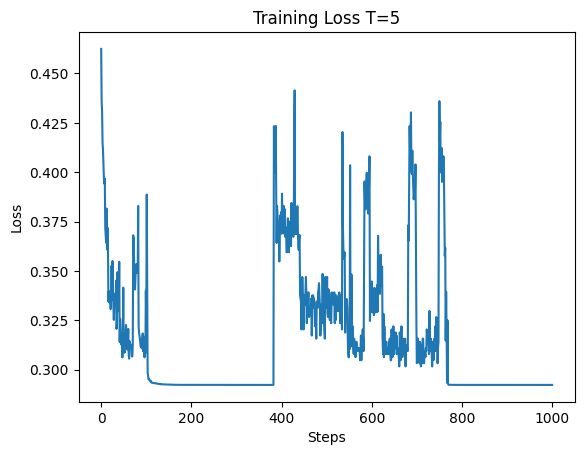

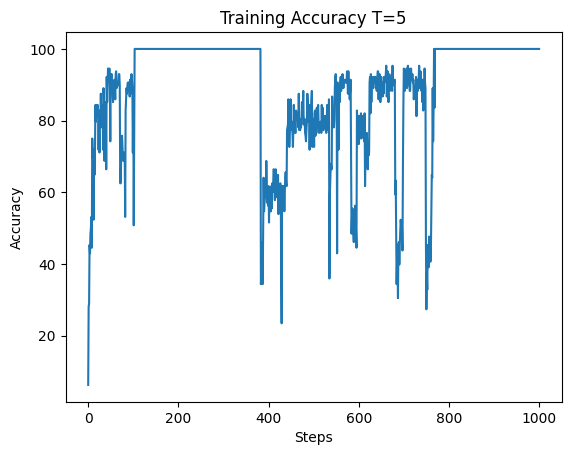

In [9]:
# Plot the losses
plot_loss(losses, title='Training Loss T=5', path=results_path + 'training_loss_5_rnn.png')

# Plot accuracies
plot_accuracy(accuracies, title='Training Accuracy T=5', path=results_path + 'training_accuracy_5_rnn.png')

Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Finished Testing


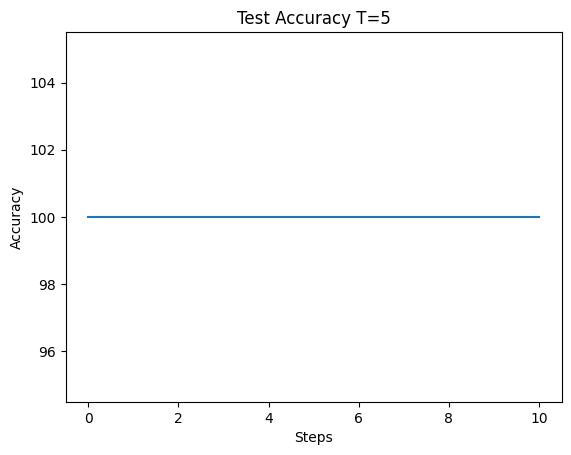

Average test accuracy: 100.00%


In [10]:
# Test the model
test_accuracies = test(model, config)

# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy T=5', path=results_path + 'test_accuracy_5_rnn.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

### Task 2: Vanilla RNN in PyTorch

In [11]:
# Train the model on T=10
model, losses, accuracies = train(config, input_length=p1[1], type='RNN', device=device)
# Add accuracies
p2_acc_rnn.append(accuracies)

[step:     0] loss: 0.4619 acc: 7.8125 time: 1547223037
[step:    10] loss: 0.4680 acc: 6.2500 time: 1547223037


<ipython-input-5-bfc30801ac03>:50: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:    20] loss: 0.4547 acc: 13.2812 time: 1547223037
[step:    30] loss: 0.4317 acc: 29.6875 time: 1547223037
[step:    40] loss: 0.4576 acc: 13.2812 time: 1547223038
[step:    50] loss: 0.4250 acc: 39.8438 time: 1547223038
[step:    60] loss: 0.4404 acc: 21.8750 time: 1547223038
[step:    70] loss: 0.4290 acc: 28.1250 time: 1547223038
[step:    80] loss: 0.4137 acc: 37.5000 time: 1547223038
[step:    90] loss: 0.4358 acc: 22.6562 time: 1547223038
[step:   100] loss: 0.4312 acc: 28.1250 time: 1547223038
[step:   110] loss: 0.4219 acc: 32.0312 time: 1547223038
[step:   120] loss: 0.4049 acc: 43.7500 time: 1547223038
[step:   130] loss: 0.3925 acc: 51.5625 time: 1547223039
[step:   140] loss: 0.3917 acc: 57.0312 time: 1547223039
[step:   150] loss: 0.3829 acc: 61.7188 time: 1547223039
[step:   160] loss: 0.4066 acc: 40.6250 time: 1547223039
[step:   170] loss: 0.3862 acc: 53.9062 time: 1547223039
[step:   180] loss: 0.3895 acc: 50.7812 time: 1547223039
[step:   190] loss: 0.3805 acc:

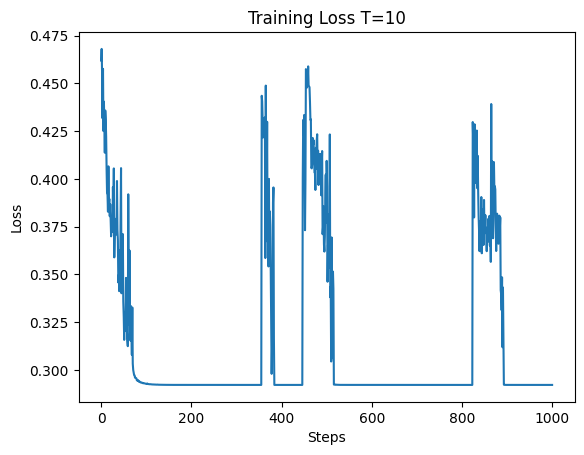

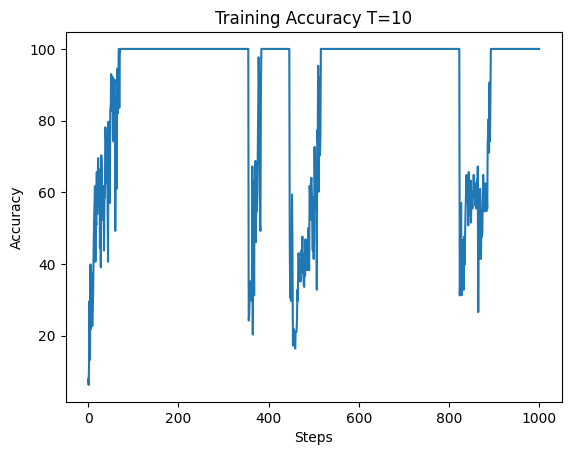

In [12]:
# Plot the losses
plot_loss(losses, title='Training Loss T=10', path=results_path + 'training_loss_5_rnn.png')

# Plot accuracies
plot_accuracy(accuracies, title='Training Accuracy T=10', path=results_path + 'training_accuracy_5_rnn.png')

Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Finished Testing


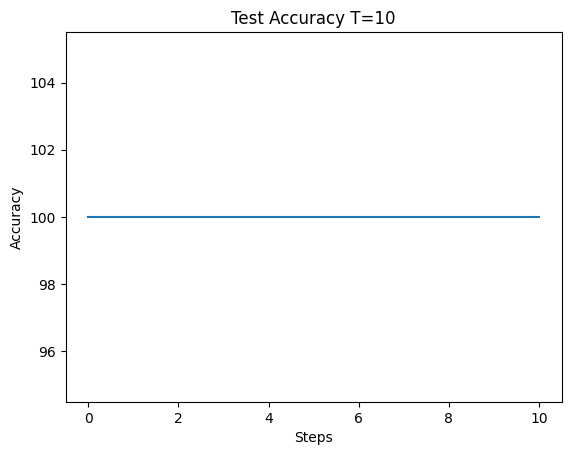

Average test accuracy: 100.00%


In [13]:
# Test the model
test_accuracies = test(model, config)

# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy T=10', path=results_path + 'test_accuracy_10_rnn.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

In [ ]:
# Train the model on T=15
model, losses, accuracies = train(config, input_length=p1[2], type='RNN', device=device)
# Add accuracies
p2_acc_rnn.append(accuracies)

[step:     0] loss: 0.4586 acc: 14.0625 time: 1547223159


<ipython-input-5-bfc30801ac03>:50: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:    10] loss: 0.4637 acc: 7.8125 time: 1547223159
[step:    20] loss: 0.4578 acc: 12.5000 time: 1547223159
[step:    30] loss: 0.4475 acc: 20.3125 time: 1547223160
[step:    40] loss: 0.4409 acc: 20.3125 time: 1547223160
[step:    50] loss: 0.4372 acc: 26.5625 time: 1547223160
[step:    60] loss: 0.4392 acc: 25.7812 time: 1547223160
[step:    70] loss: 0.4347 acc: 28.1250 time: 1547223160
[step:    80] loss: 0.4160 acc: 43.7500 time: 1547223161
[step:    90] loss: 0.4203 acc: 36.7188 time: 1547223161
[step:   100] loss: 0.4175 acc: 39.0625 time: 1547223161
[step:   110] loss: 0.4217 acc: 31.2500 time: 1547223161
[step:   120] loss: 0.4034 acc: 41.4062 time: 1547223161
[step:   130] loss: 0.4037 acc: 42.1875 time: 1547223162
[step:   140] loss: 0.4090 acc: 40.6250 time: 1547223162
[step:   150] loss: 0.4173 acc: 36.7188 time: 1547223162
[step:   160] loss: 0.4075 acc: 42.9688 time: 1547223162
[step:   170] loss: 0.4181 acc: 36.7188 time: 1547223162
[step:   180] loss: 0.4025 acc: 

In [ ]:
# Plot the losses
plot_loss(losses, title='Training Loss T=15', path=results_path + 'training_loss_15_rnn.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy T=15', path=results_path + 'training_accuracy_15_rnn.png')

In [ ]:
# Test the model
test_accuracies = test(model, config)

# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy T=15', path=results_path + 'test_accuracy_15_rnn.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

In [ ]:
# Train the model on T=20
model, losses, accuracies = train(config, input_length=p1[3], type='RNN', device=device)
# Add accuracies
p2_acc_rnn.append(accuracies)


In [ ]:
# Plot the losses
plot_loss(losses, title='Training Loss T=20', path=results_path + 'training_loss_20_rnn.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy T=20', path=results_path + 'training_accuracy_20_rnn.png')

In [ ]:
# Test the model
test_accuracies = test(model, config)

# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy T=20', path=results_path + 'test_accuracy_20_rnn.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

### Task 3: Long-Short Term Network (LSTM) in PyTorch

In [ ]:
class LSTM(nn.Module):

    def __init__(self, seq_length, input_dim, num_hidden, num_classes, batch_size=128, device=None):
        super(LSTM, self).__init__()

        self.seq_length = seq_length
        self.input_dim = input_dim
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.batch_size = batch_size

        if device is None:
          device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.device = device

        # Hidden Layer
        self.W_gx = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))
        self.W_gh = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))
        self.B_g = nn.Parameter(torch.Tensor(self.num_hidden))

        # Cell State
        # (1) Input gate
        self.W_ix = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))
        self.W_ih = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))
        self.B_i = nn.Parameter(torch.Tensor(self.num_hidden))

        # (2) Forget gate
        self.W_fx = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))
        self.W_fh = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))
        self.B_f = nn.Parameter(torch.Tensor(self.num_hidden))

        # (3) Output gate
        self.W_ox = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))
        self.W_oh = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))
        self.B_o = nn.Parameter(torch.Tensor(self.num_hidden))

        # Output Layer
        self.W_ph = nn.Parameter(torch.Tensor(self.num_hidden, self.num_classes))
        self.B_y = nn.Parameter(torch.Tensor(self.num_classes))

        # Initialize weights
        self.init_weights()


    def forward(self, x):
        # Initialize hidden state and cell state
        h_t = torch.zeros(self.batch_size, self.self.num_hidden, device=self.device)
        c_t = torch.zeros(self.batch_size, self.self.num_hidden, device=self.device)

        for t in range(self.seq_length):
            x_t = x[:, t].view(self.batch_size, -1)

            # Compute the hidden state
            g_t = torch.tanh(x_t @ self.W_gx + h_t @ self.W_gh + self.B_g)
            i_t = torch.sigmoid(x_t @ self.W_ix + h_t @ self.W_ih + self.B_i)
            f_t = torch.sigmoid(x_t @ self.W_fx + h_t @ self.W_fh + self.B_f)
            o_t = torch.sigmoid(x_t @ self.W_ox + h_t @ self.W_oh + self.B_o)

            # Add everything up to the cell state
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)

        # Compute the output
        output = h_t @ self.W_ph + self.B_y
        y = torch.softmax(output, dim=1)
        return y

    def init_weights(self):
        """ Keep weights in a similar range to avoid
            gradients vanishing or exploding.
        """
        # Initialize weights
        nn.init.xavier_normal_(self.W_gx)
        nn.init.xavier_normal_(self.W_gh)
        nn.init.xavier_normal_(self.W_ix)
        nn.init.xavier_normal_(self.W_ih)
        nn.init.xavier_normal_(self.W_fx)
        nn.init.xavier_normal_(self.W_fh)
        nn.init.xavier_normal_(self.W_ox)
        nn.init.xavier_normal_(self.W_oh)
        nn.init.xavier_normal_(self.W_ph)
        nn.init.zeros_(self.B_g)
        nn.init.zeros_(self.B_i)
        nn.init.zeros_(self.B_f)
        nn.init.zeros_(self.B_o)
        nn.init.zeros_(self.B_y)

    def init_hidden(self):
        # Initialize hidden state
        self.hidden_state = torch.zeros(self.batch_size, self.self.num_hidden, device=self.device)

    def set_grad(self, requires_grad):
        # Set requires_grad for all parameters
        for param in self.parameters():
            param.requires_grad = requires_grad

In [ ]:
# Train the model T=5
model, losses, accuracies = train(config, input_length=p1[0], type='LSTM', device=device)

# Add accuracies
p3_acc_lstm.append(accuracies)

In [ ]:
# Plot the losses
plot_loss(losses, title='Training Loss T=5', path=results_path + 'training_loss_5_lstm.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy', path=results_path + 'training_accuracy_5_lstm.png')

In [ ]:
# Test the model
test_accuracies = test(model, config)

# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy', path=results_path + 'test_accuracy_5_lstm.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

In [ ]:
# Train the model T=10
model, losses, accuracies = train(config, input_length=p1[1], type='LSTM', device=device)

# Add accuracies
p3_acc_lstm.append(accuracies)

In [ ]:
# Plot the losses
plot_loss(losses, title='Training Loss T=10', path=results_path + 'training_loss_10_lstm.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy', path=results_path + 'training_accuracy_10_lstm.png')

In [ ]:
# Test the model
test_accuracies = test(model, config)

# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy', path=results_path + 'test_accuracy_10_lstm.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

In [ ]:
# Train the model T=15
model, losses, accuracies = train(config, input_length=p1[2], type='LSTM', device=device)

# Add accuracies
p3_acc_lstm.append(accuracies)


In [ ]:
# Plot the losses
plot_loss(losses, title='Training Loss T=15', path=results_path + 'training_loss_15_lstm.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy', path=results_path + 'training_accuracy_15_lstm.png')

In [ ]:
# Test the model
test_accuracies = test(model, config)

# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy', path=results_path + 'test_accuracy_15_lstm.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

In [ ]:
# Train the model T=20
model, losses, accuracies = train(config, input_length=p1[3], type='LSTM', device=device)

# Add accuracies
p3_acc_lstm.append(accuracies)

In [ ]:
# Plot the losses
plot_loss(losses, title='Training Loss T=20', path=results_path + 'training_loss_20_lstm.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy', path=results_path + 'training_accuracy_20_lstm.png')

In [ ]:
# Test the model
test_accuracies = test(model, config)

# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy', path=results_path + 'test_accuracy_20_lstm.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

In [ ]:
plt.title('Accuracy w.r.t. palindromes length.')
plt.plot(p1, p2_acc_rnn, color='red', label='RNN')
plt.scatter(p1, p2_acc_rnn, color='red')

plt.plot(p1, p3_acc_lstm, color='green', label='LSTM')
plt.scatter(p1, p3_acc_lstm, color='green')

plt.xlabel('Palindromes Length')
plt.ylabel('Accuracy')
plt.legend()
plt.show()